## load data

In [137]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
# Load the CSV file into a pandas DataFrame
from datetime import datetime

import numpy as np

# Set the aesthetics for the seaborn plots
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
plt.rcParams.update({"xtick.labelsize": 17, "ytick.labelsize": 17,
"axes.titlesize": 18, "axes.titleweight": 'bold', "axes.labelsize": 19, "axes.labelweight": 'bold'})
pd.set_option('display.max_columns', 50)


In [143]:
def load_dataframe(path="../results/all_results.csv", columns=None):
    # Load the DataFrame
    df = pd.read_csv(path)
    # Convert the 'timestamp' column to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d_%H-%M-%S')

    # Select only the specified columns if the 'columns' parameter is provided
    if columns is not None:
        df = df[columns]

    # Remove rows where 'total weight' is NaN
    df = df.dropna(subset=['total_weights'])
    df = df[(df.regularization != 'dropout') & (df.regularization != 'l_infinty')]
    return df

def create_pivot_table(df, model_name, dataset_name, regularization, metric='test_loss'):
    # Filter the DataFrame based on the input parameters
    filtered_df = df[(df['model_name'] == model_name) & 
                     (df['dataset_name'] == dataset_name) & 
                     (df['regularization'] == regularization)]

    # List of bit widths to consider
    bit_widths = [32, 16, 8, 4, 2]

    # Create a new DataFrame for the pivot table
    pivot_data = []

    for bit in bit_widths:
        if bit == 32:
            # For bit width 32, use the 'test_loss' column
            col_name = metric
        else:
            # For other bit widths, use the 'bit_{i}_{metric}' format
            col_name = f'bit_{bit}_{metric}'

        # Check if the column exists in the DataFrame
        if col_name in filtered_df.columns:
            # Extract the required values and add to the pivot data
            for index, row in filtered_df.iterrows():
                pivot_data.append({'Bit Width': f'bit_{bit}', 
                                   'Regularization Param': row['regularization_param'], 
                                   metric: row[col_name]})

    # Convert the list of data into a DataFrame
    pivot_df = pd.DataFrame(pivot_data)

    # Sort the DataFrame by 'Bit Width' in descending order
    pivot_df['Bit Width'] = pd.Categorical(pivot_df['Bit Width'], 
                                           categories=[f'bit_{b}' for b in bit_widths], 
                                           ordered=True)
    pivot_df = pivot_df.sort_values('Bit Width', ascending=False)

    # Create the pivot table
    pivot_table = pivot_df.pivot(index='Bit Width', columns='Regularization Param', values=metric)

    return pivot_table

def my_eval(x):
    try:
        return eval(x)
    except:
        print(x)
        return x



In [144]:
cols = ['total_weights','model_name', 'dataset_name','regularization', 'regularization_param','optimizer_name',
 'train_loss', 'test_loss', 'train_accuracy', 'test_accuracy','lr', "epoch_test_losses"] + [f'bit_{i}_test_accuracy' for i in [16, 8, 4, 2]]
df = load_dataframe(columns = cols)
df.shape

(38, 16)

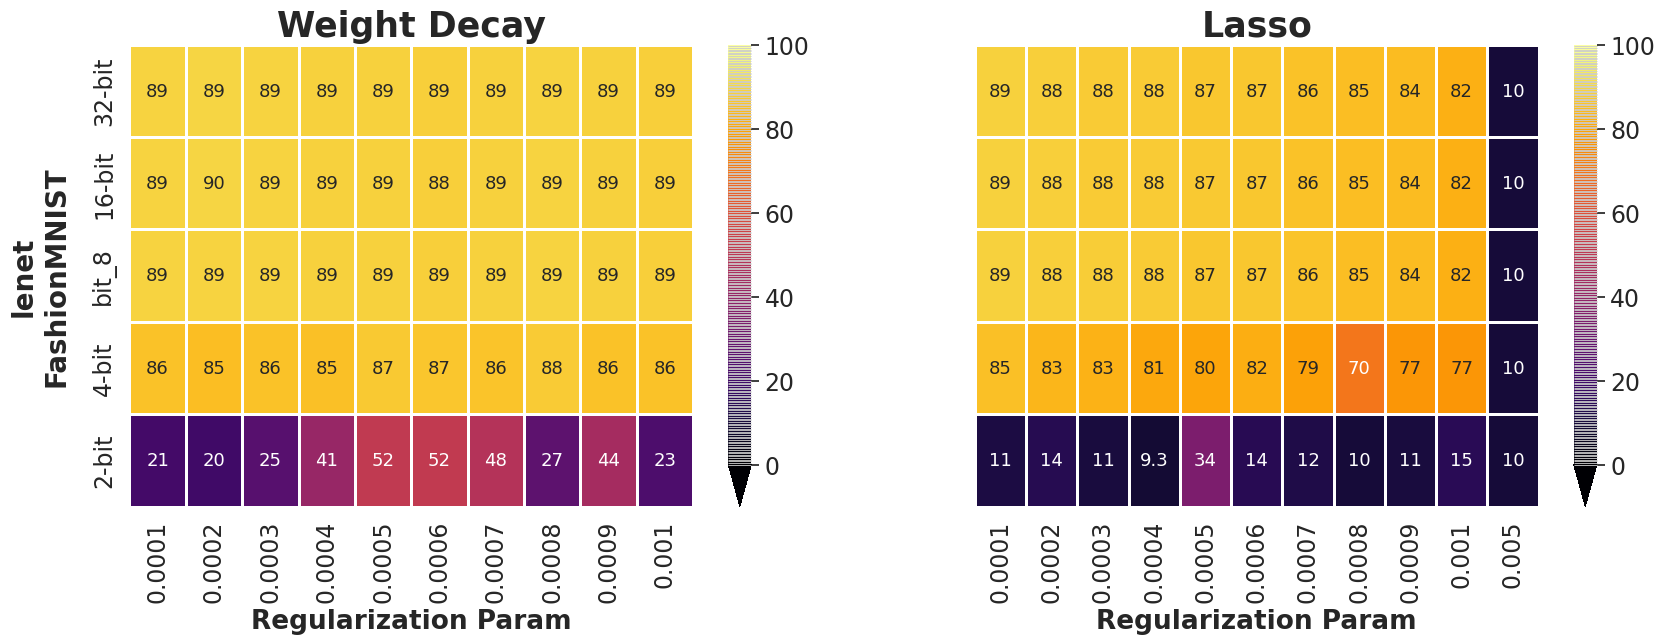

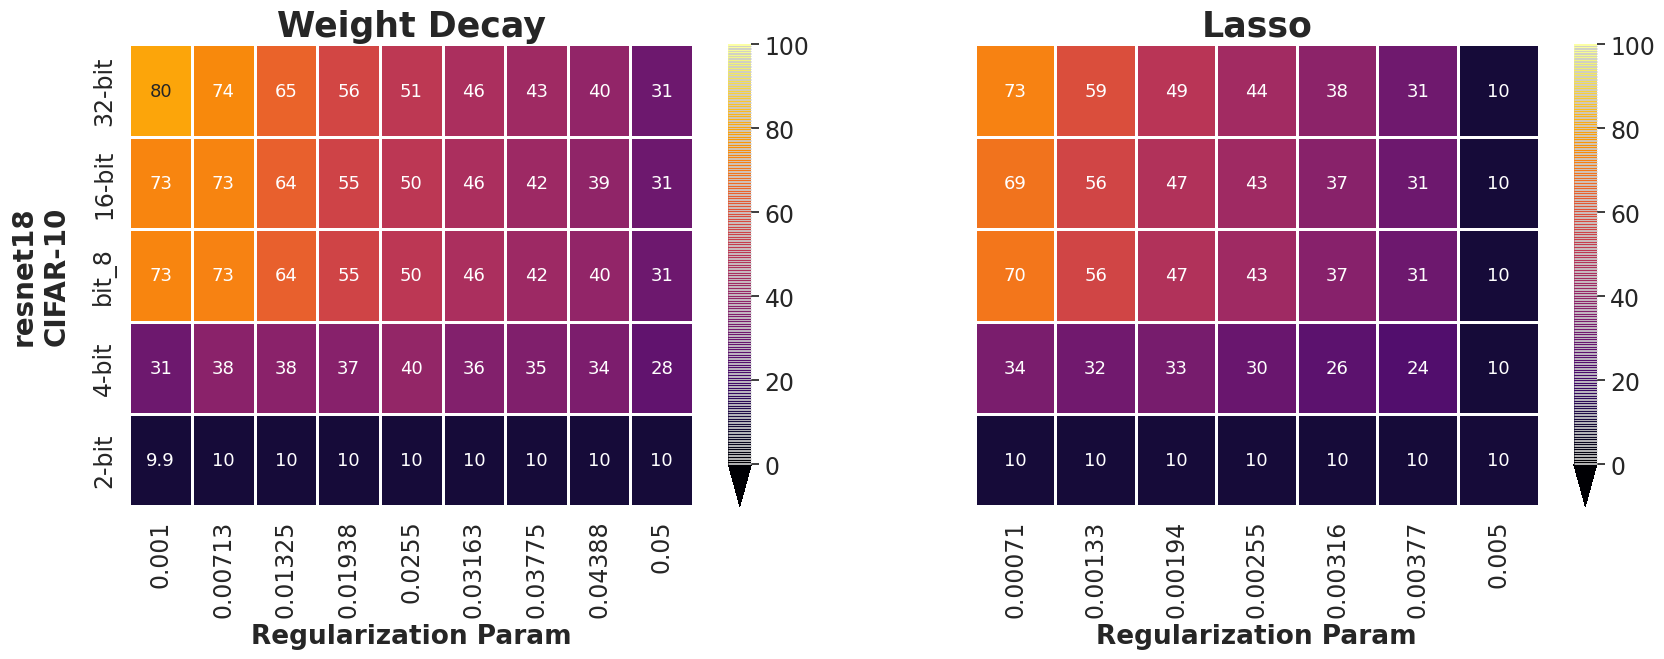

In [165]:


def plot_heatmap(ax, pivot_table, regularization, metric, set_ylabel=True, set_xlabel=True, model_name='', dataset_name='', title=""):
    cbar_kws = {"orientation": "vertical", 
                "shrink": 1,
                'extend': 'min', 
                'extendfrac': 0.1, 
                "drawedges": True}

    # Plot heatmap
    sns.heatmap(pivot_table, annot=True, vmin=0, vmax=100, fmt=".2g", annot_kws={'size': 13}, 
                linewidths=1, cmap="inferno", cbar_kws=cbar_kws, ax=ax)

    # Dictionary for renaming tick labels
    rename_dict = {'bit_2': '2-bit', 'bit_4': '4-bit', 'bit_16': '16-bit', 'bit_32': '32-bit'}

    # Set custom tick labels for quantization levels
    ax.set_xticklabels([rename_dict.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()])
    if set_ylabel:
        ax.set_yticklabels([rename_dict.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()])
        ax.set_ylabel(f"{model_name}\n{dataset_name}", rotation=90, labelpad=15, fontsize=20)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])
    if not set_xlabel:
        ax.set_xlabel('')
    if title:
        ax.set_title(title, fontsize=25)
    



metric = 'test_accuracy'
unique_datasets = df['dataset_name'].drop_duplicates().dropna()

for dataset_name in unique_datasets:
    # Filter the unique combinations of model_name and regularization for this dataset
    unique_pairs = df[df['dataset_name'] == dataset_name][['model_name', 'regularization']].drop_duplicates().dropna()

    # Number of plots (subplots) needed for this dataset
    n_plots = 2

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, n_plots, figsize=(10 * n_plots, 6))  # Adjust the size as needed
    titles={"l2":"Weight Decay", "l1":'Lasso'}
    for i, (model_name, regularization) in enumerate(unique_pairs.values):
        if regularization != "none":
            tmp = df[
                (df.model_name == model_name) & (df.dataset_name == dataset_name) & (df.regularization == regularization)
            ]
            pivot_table = create_pivot_table(tmp, model_name, dataset_name, regularization, metric)

            # Plot heatmap in the ith subplot
            if n_plots > 1:
                ax = axes[i]
            else:
                ax = axes  # If there's only one plot, axes is not a list
            plot_heatmap(ax, pivot_table, regularization, metric, (i==0), True, model_name, dataset_name, title=titles[regularization])

    # Save the entire figure as a PNG file
    fig.savefig(f"../plots/test_accuracy_{dataset_name}.png", bbox_inches='tight')
    plt.show()  # Display the figure

    # This loop will create a single figure for each dataset, with multiple subplots in a row
